# Galaxy10 + CNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
BASE = Path().resolve().parent
print(f'BASE: {BASE}')

import torch
torch.manual_seed(0)

IS_MPS_AVAILABLE = torch.backends.mps.is_available() and torch.backends.mps.is_built()
print(f'Is mps avaliable? : {IS_MPS_AVAILABLE}')
if not IS_MPS_AVAILABLE:
    IS_CUDA_AVAILABLE = torch.cuda.is_available()
    print(f'Is cuda avaliable? : {IS_CUDA_AVAILABLE}')
    print(f'cuda device count: {torch.cuda.device_count()}')
    print(f'cuda current device: {torch.cuda.current_device()}')
    print(f'cuda device name: {torch.cuda.get_device_name()}')
    # switch to cuda if available, else mps, else cpu
    DEVICE = torch.device('cuda' if IS_CUDA_AVAILABLE else 'cpu')
    print(f'device: {DEVICE}')

import h5py
from tqdm import tqdm

from sklearn.model_selection import train_test_split

BASE: C:\Users\zheng\Documents\GitHub\SDSSGalCat
Is mps avaliable? : False
Is cuda avaliable? : True
cuda device count: 1
cuda current device: 0
cuda device name: NVIDIA GeForce RTX 4060 Ti
device: cuda


In [2]:
# load data
# data ref: https://astronn.readthedocs.io/en/stable/galaxy10sdss.html

with h5py.File(BASE / 'data/Galaxy10.h5', 'r') as f:
    images = f['images'][:]
    labels = f['ans'][:]

print(f'images.shape: {images.shape}, labels.shape: {labels.shape}')
assert images.shape[0] == labels.shape[0]

images.shape: (21785, 69, 69, 3), labels.shape: (21785,)


In [3]:
# split the data, 90% for training and 10% for testing
# make sure that there are equal number of samples for each class in the training and testing set
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=0)
print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}')

X_train.shape: (17428, 69, 69, 3), y_train.shape: (17428,)
X_test.shape: (4357, 69, 69, 3), y_test.shape: (4357,)


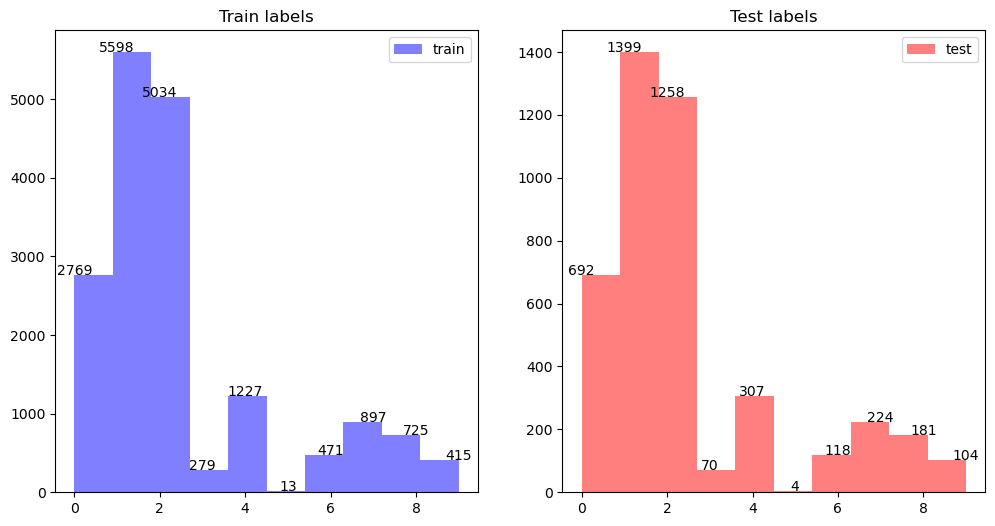

In [4]:
# visualize the splited data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(y_train, bins=10, color='blue', alpha=0.5, label='train')
for i in range(10):
    ax[0].text(i, y_train.tolist().count(i), str(y_train.tolist().count(i)), color='black', ha='center')
ax[0].set_title('Train labels')
ax[0].legend()

ax[1].hist(y_test, bins=10, color='red', alpha=0.5, label='test')
for i in range(10):
    ax[1].text(i, y_test.tolist().count(i), str(y_test.tolist().count(i)), color='black', ha='center')
ax[1].set_title('Test labels')
ax[1].legend()

plt.show()
plt.close()

In [5]:
# built a torch CNN 
# ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # input is a 3 channel image with 69x69 pixels, output is 10 classes
        # cov calculator: http://www.sqflash.com/cal.html

        self.conv1 = torch.nn.Conv2d(3, 6, 5)   # out 65*65, 32*32 after pool
        self.conv2 = torch.nn.Conv2d(6, 16, 5)  # out 28*28, 14*14 after pool

        self.pool = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(16 * 14 * 14, 512)   # 3136 -> 512
        self.fc2 = torch.nn.Linear(512, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_CNN = CNN()
if IS_CUDA_AVAILABLE:
    net_CNN = net_CNN.to(DEVICE)

In [6]:
# define the optimizer and loss function
crit = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(net_CNN.parameters(), lr=0.001, momentum=0.9)

Epoch 1/32:   0%|          | 0/34 [00:00<?, ?it/s]e:\Anaconda\envs\torch230\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/32: 35it [00:01, 20.04it/s]                        


Epoch 1 loss: 1.788492612070465


Epoch 2/32: 35it [00:01, 34.19it/s]                        


Epoch 2 loss: 1.616461739180037


Epoch 3/32: 35it [00:01, 34.17it/s]                        


Epoch 3 loss: 1.4654849203239757


Epoch 4/32: 35it [00:01, 34.31it/s]                        


Epoch 4 loss: 1.3066340269833385


Epoch 5/32: 35it [00:01, 33.70it/s]                        


Epoch 5 loss: 1.1225804680663838


Epoch 6/32: 35it [00:00, 37.02it/s]                        


Epoch 6 loss: 0.9817784510540913


Epoch 7/32: 35it [00:00, 37.14it/s]                        


Epoch 7 loss: 0.9148871260059244


Epoch 8/32: 35it [00:00, 37.08it/s]                        


Epoch 8 loss: 0.8782580736609864


Epoch 9/32: 35it [00:00, 36.89it/s]                        


Epoch 9 loss: 0.8179626885099588


Epoch 10/32: 35it [00:00, 36.99it/s]                        


Epoch 10 loss: 0.7831138416471518


Epoch 11/32: 35it [00:00, 37.26it/s]                        


Epoch 11 loss: 0.7706402027199294


Epoch 12/32: 35it [00:00, 37.08it/s]                        


Epoch 12 loss: 0.7209948201997033


Epoch 13/32: 35it [00:00, 37.23it/s]                        


Epoch 13 loss: 0.6852109040966651


Epoch 14/32: 35it [00:00, 37.00it/s]                        


Epoch 14 loss: 0.6813384382883999


Epoch 15/32: 35it [00:00, 37.00it/s]                        


Epoch 15 loss: 0.6313105975648584


Epoch 16/32: 35it [00:00, 37.18it/s]                        


Epoch 16 loss: 0.623177003280433


Epoch 17/32: 35it [00:00, 37.02it/s]                        


Epoch 17 loss: 0.6235631085164454


Epoch 18/32: 35it [00:00, 37.01it/s]                        


Epoch 18 loss: 0.6158135821027495


Epoch 19/32: 35it [00:00, 37.13it/s]                        


Epoch 19 loss: 0.582068591920066


Epoch 20/32: 35it [00:00, 37.08it/s]                        


Epoch 20 loss: 0.5530722558785667


Epoch 21/32: 35it [00:00, 37.14it/s]                        


Epoch 21 loss: 0.5403690933497203


Epoch 22/32: 35it [00:00, 37.04it/s]                        


Epoch 22 loss: 0.5372652100236257


Epoch 23/32: 35it [00:00, 36.85it/s]                        


Epoch 23 loss: 0.5563532039335022


Epoch 24/32: 35it [00:00, 36.90it/s]                        


Epoch 24 loss: 0.5022709885676684


Epoch 25/32: 35it [00:00, 36.90it/s]                        


Epoch 25 loss: 0.47312528747250404


Epoch 26/32: 35it [00:00, 36.95it/s]                        


Epoch 26 loss: 0.4611778885283436


Epoch 27/32: 35it [00:00, 37.04it/s]                        


Epoch 27 loss: 0.45926269905978123


Epoch 28/32: 35it [00:00, 36.98it/s]                        


Epoch 28 loss: 0.4869069295764544


Epoch 29/32: 35it [00:00, 37.05it/s]                        


Epoch 29 loss: 0.473111163374205


Epoch 30/32: 35it [00:00, 36.96it/s]                        


Epoch 30 loss: 0.4568602614701547


Epoch 31/32: 35it [00:00, 36.83it/s]                        


Epoch 31 loss: 0.4286887486483872


Epoch 32/32: 35it [00:00, 36.87it/s]                        


Epoch 32 loss: 0.38776577550499763


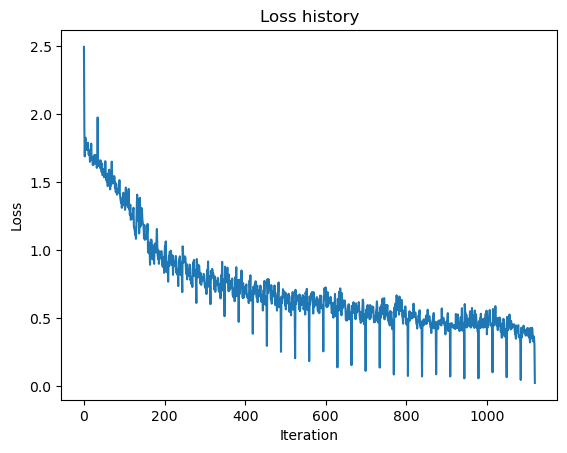

In [7]:
EPOCH_NUM = 32
BATCH_SIZE = 512

# train the model
loss_history = []
for epoch in range(EPOCH_NUM):
    running_loss = 0.0
    for i in tqdm(
            range(0, X_train.shape[0], BATCH_SIZE), 
            # show running loss
            desc=f'Epoch {epoch+1}/{EPOCH_NUM}',
            total=X_train.shape[0]//BATCH_SIZE, 
            # realtime progress bar
            dynamic_ncols=True,
        ):
        # transpose the data to torch tensor
        this_inputs = torch.tensor(X_train[i:i+BATCH_SIZE]).permute(0, 3, 1, 2).float()
        this_labels = torch.tensor(y_train[i:i+BATCH_SIZE]).long()

        if IS_CUDA_AVAILABLE:
            this_inputs = this_inputs.to(DEVICE)
            this_labels = this_labels.to(DEVICE)

        optim.zero_grad()

        outputs = net_CNN(this_inputs)
        loss = crit(outputs, this_labels)
        loss.backward()
        optim.step()

        loss_history.append(loss.item())
        running_loss += loss.item()

    print(f'Epoch {epoch+1} loss: {running_loss / (X_train.shape[0] / BATCH_SIZE)}')

# show history
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()
plt.close()

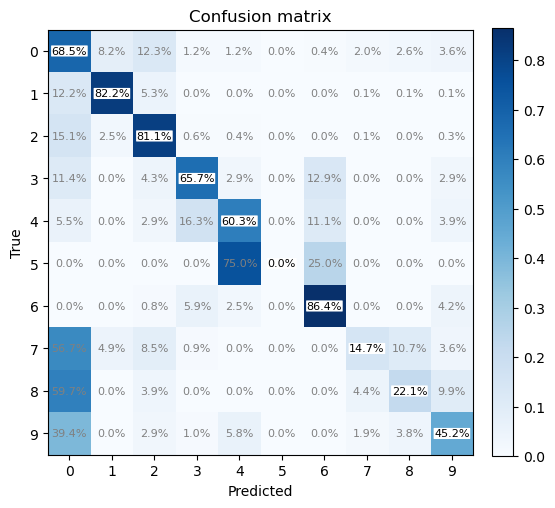

Overall Precision: 0.551, Recall: 0.526, F score: 0.511
   Class  Precision    Recall   F score
0      0   0.417254  0.684971  0.518600
1      1   0.920737  0.822016  0.868580
2      2   0.835381  0.810811  0.822912
3      3   0.380165  0.657143  0.481675
4      4   0.872642  0.602606  0.712909
5      5   0.000000  0.000000  0.000000
6      6   0.684564  0.864407  0.764045
7      7   0.559322  0.147321  0.233216
8      8   0.459770  0.220994  0.298507
9      9   0.382114  0.451923  0.414097


e:\Anaconda\envs\torch230\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Anaconda\envs\torch230\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


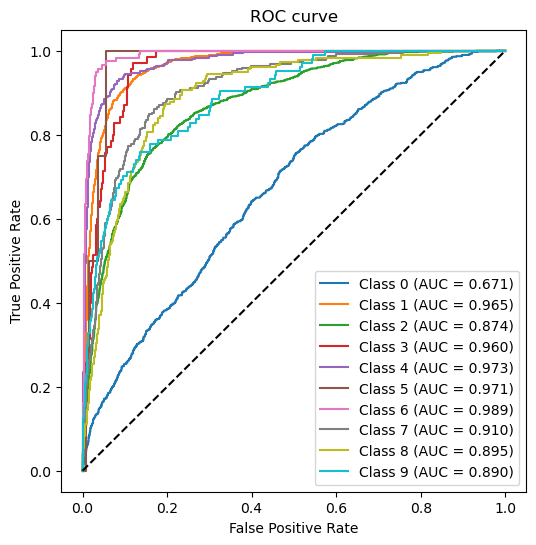

In [10]:
# confusion matrix
from sklearn.metrics import confusion_matrix

with torch.no_grad():
    test_inputs = torch.tensor(X_test).permute(0, 3, 1, 2).float()
    test_labels = torch.tensor(y_test).long()

    if IS_CUDA_AVAILABLE:
        test_inputs = test_inputs.to(DEVICE)
        test_labels = test_labels.to(DEVICE)

    outputs = net_CNN(test_inputs)
    _, predicted = torch.max(outputs, 1)

if IS_CUDA_AVAILABLE:
    y_outputs = outputs.cpu().numpy()
    y_pred = predicted.cpu().numpy()
else:
    y_outputs = outputs.numpy()
    y_pred = predicted.numpy()

confmat = confusion_matrix(y_test, y_pred, labels=range(10), normalize='true')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cax = ax.matshow(confmat, cmap='Blues')
# colorbar lim: 0-1
fig.colorbar(cax, fraction=0.046, pad=0.04, ticks=np.arange(0, 1.1, 0.1))
plt.title('Confusion matrix')
for i in range(10):
    for j in range(10):
        plt.text(j, i, f'{confmat[i, j]*100:.1f}%', ha='center', va='center', color='grey', fontsize=8)
plt.xticks(ticks=range(10), labels=range(10))
plt.yticks(ticks=range(10), labels=range(10))
# accuarcy for each label
for i in range(10):
    # text with border
    plt.text(i, i, f'{confmat[i, i]*100:.1f}%', ha='center', va='center', color='k', fontsize=8, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.05'))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()
plt.close()

# precision, recall, F score
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f'Overall Precision: {precision:.3f}, Recall: {recall:.3f}, F score: {f_score:.3f}')

# for each class
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
df_res = pd.DataFrame({
    'Class': range(10),
    'Precision': precision,
    'Recall': recall,
    'F score': f_score,
})
print(df_res)

# roc curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

y_test_bin = label_binarize(y_test, classes=range(10))
y_outputs_bin = y_outputs
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_outputs_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(10):
    ax.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.3f})')
ax.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
plt.close()